In [1]:
import os 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import class_weight
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, VGG16, DenseNet121
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import ceil
from keras.regularizers import l2

Using TensorFlow backend.
/home/abhijadhav/anaconda3/envs/keras-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abhijadhav/anaconda3/envs/keras-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abhijadhav/anaconda3/envs/keras-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
keras.__version__
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    './data/cropped_multiclass/train',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    './data/cropped_multiclass/val',
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))

Found 20242 images belonging to 8 classes.
Found 5089 images belonging to 8 classes.


In [4]:
df = pd.read_csv('data/ISIC_2019_Training_GroundTruth.csv')
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)
print(class_weights)


[ 3.69919591  0.96870214  1.18624004 12.71482412  0.69588834  0.24620512
  5.08082329 12.46428571]


/home/abhijadhav/anaconda3/envs/keras-gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[0 0 0 ... 7 7 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [5]:
model_dir = 'models/keras/patience8_densenet_multiclass_128/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
patience = 8

In [6]:
conv_base = DenseNet121(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
predictions = layers.Dense(8, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [8]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

optimizer = keras.optimizers.Adam()
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
             ModelCheckpoint(filepath= model_dir +'best_model.h5', monitor='val_loss', save_best_only=True)]

callbacks_ft = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath= model_dir +'best_model_ft.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', top3_acc])

In [9]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=validation_generator, callbacks=callbacks, workers=4, class_weight=class_weights, steps_per_epoch=ceil(20242//32), validation_steps=ceil(5089//32))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
632/632 [==============================] - 241s 382ms/step - loss: 1.9425 - accuracy: 0.5941 - top3_acc: 0.8738 - val_loss: 12.9043 - val_accuracy: 0.5096 - val_top3_acc: 0.8239
Epoch 2/100
632/632 [==============================] - 116s 183ms/step - loss: 1.2913 - accuracy: 0.6301 - top3_acc: 0.8958 - val_loss: 5.7154 - val_accuracy: 0.5278 - val_top3_acc: 0.8432
Epoch 3/100
632/632 [==============================] - 118s 186ms/step - loss: 1.1342 - accuracy: 0.6326 - top3_acc: 0.9014 - val_loss: 10.3567 - val_accuracy: 0.5258 - val_top3_acc: 0.8511
Epoch 4/100
632/632 [==============================] - 119s 189ms/step - loss: 1.1122 - accuracy: 0.6281 - top3_acc: 0.8985 - val_loss: 5.5008 - val_accuracy: 0.5011 - val_top3_acc: 0.8493
Epoch 5/100
632/632 [==============================] - 117s 185ms/step - loss: 1.0866 - accuracy: 0.6345 - top3_acc: 0.9017 - val_loss: 6.1652 - val_accuracy: 0.4613 - val_top3_acc: 0.8491
Epoch

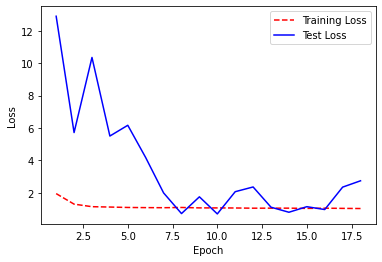

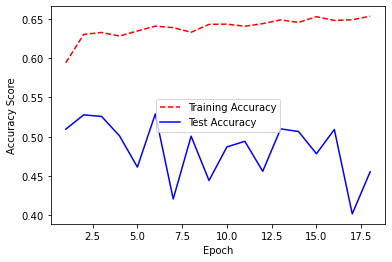

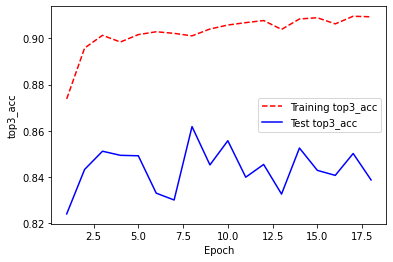

In [10]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(model_dir + 'loss.png')

# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Visualize accuracy history
plt.figure(2)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.savefig(model_dir + 'acc.png')

# Get training and test catkacc histories
training_top3_acc = history.history['top3_acc']
test_top3_acc = history.history['val_top3_acc']

# Visualize loss history
plt.figure(3)
plt.plot(epoch_count, training_top3_acc, 'r--')
plt.plot(epoch_count, test_top3_acc, 'b-')
plt.legend(['Training top3_acc', 'Test top3_acc'])
plt.xlabel('Epoch')
plt.ylabel('top3_acc')
plt.savefig(model_dir + 'top3_acc.png')

In [11]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

dependencies = {
    'top3_acc': top3_acc
}

from sklearn.metrics import roc_curve, roc_auc_score
best_model = load_model(model_dir + 'best_model.h5', custom_objects=dependencies)
logits = best_model.predict_generator(validation_generator)
y_actual = validation_generator.classes
y_pred = np.argmax((logits), axis = 1)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_actual, y_pred)
print(bal_acc)

y = np.bincount(y_actual)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii])).T)


y = np.bincount(y_pred)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii])).T)

matrix = confusion_matrix(y_actual, y_pred)
print(matrix)

0.1597472605683735
[[   0  183]
 [   1  711]
 [   2  491]
 [   3   40]
 [   4  886]
 [   5 2598]
 [   6  130]
 [   7   50]]
[[   1  102]
 [   4 1449]
 [   5 3538]]
[[   0    6    0    0   86   91    0    0]
 [   0   26    0    0  287  398    0    0]
 [   0    5    0    0  122  364    0    0]
 [   0    2    0    0   10   28    0    0]
 [   0    4    0    0  396  486    0    0]
 [   0   52    0    0  482 2064    0    0]
 [   0    6    0    0   54   70    0    0]
 [   0    1    0    0   12   37    0    0]]


/home/abhijadhav/anaconda3/envs/keras-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


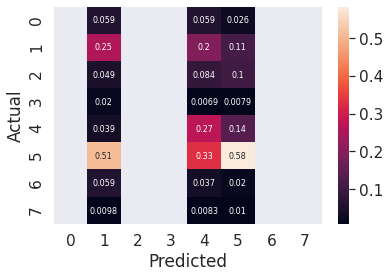

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = matrix / matrix.sum(axis=0)

df_cm = pd.DataFrame(matrix, range(8), range(8))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
best_model = load_model(model_dir + 'best_model.h5')
y_pred = best_model.predict_generator(validation_generator)[:,1]
y_actual = validation_generator.classes
fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
auc = roc_auc_score(y_actual, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(model_dir + 'roc_auc.png')